Creating RawArray with float64 data, n_channels=9, n_times=90103
    Range : 0 ... 90102 =      0.000 ...   360.408 secs
Ready.
<Info | 8 non-empty values
 bads: []
 ch_names: EXG 1, EXG 2, EXG 3, EXG 4, EXG 5, EXG 6, EXG 7, EXG 8, TRIG
 chs: 9 EEG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 9
 projs: []
 sfreq: 250.0 Hz
>
Channel names: ['EXG 1', 'EXG 2', 'EXG 3', 'EXG 4', 'EXG 5', 'EXG 6', 'EXG 7', 'EXG 8', 'TRIG']
Sampling frequency: 250.0 Hz


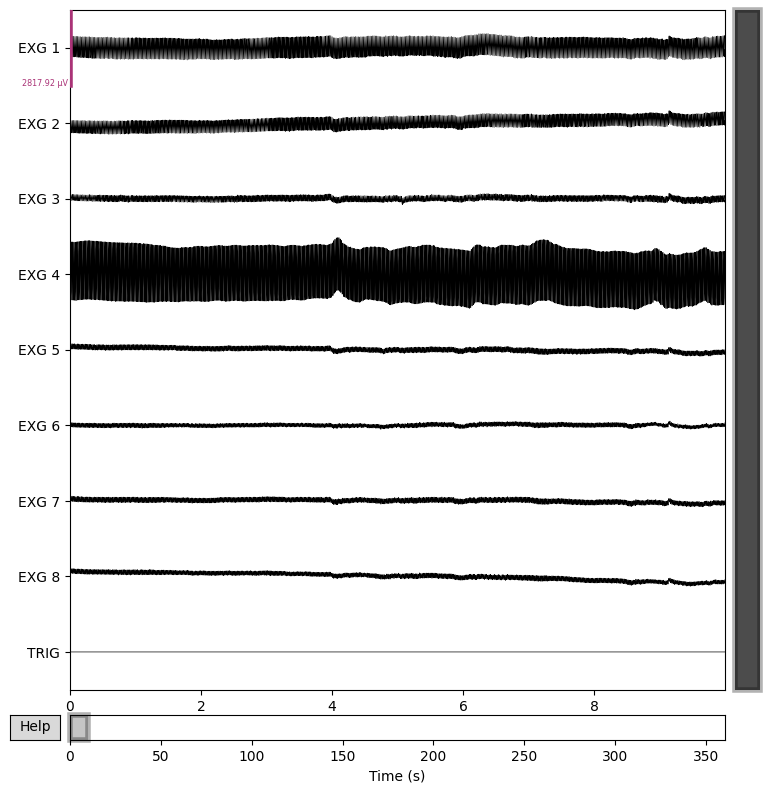

    time     EXG 1     EXG 2     EXG 3     EXG 4     EXG 5     EXG 6  \
0  0.000 -41005.97 -33663.89 -38255.77 -52497.82 -41789.44 -52602.65   
1  0.004 -41326.10 -33869.01 -38364.68 -52885.46 -41786.91 -52560.48   
2  0.008 -41456.39 -33918.29 -38392.24 -54375.65 -41665.01 -52444.08   
3  0.012 -41000.01 -33644.94 -38266.97 -54675.08 -41611.72 -52454.29   
4  0.016 -40684.37 -33467.99 -38181.33 -53582.48 -41688.16 -52559.55   

      EXG 7     EXG 8  TRIG  
0 -62214.24 -49368.29   0.0  
1 -62216.24 -49345.83   0.0  
2 -62085.18 -49216.63   0.0  
3 -62033.09 -49200.73   0.0  
4 -62110.19 -49295.07   0.0  


In [14]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

# Path to your CSV file
file_path = Path('/Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/Raw Data Recorder/UnicornRawDataRecorder_19_12_2025_11_39_340.csv')

# -------------------------------------------------------------------
# 1) Load CSV (auto-detect delimiter, skip comment lines)
#    If your file has metadata rows not starting with '#', add skiprows=...
#    If auto-detect fails, set sep=',' or sep=';' explicitly.
# -------------------------------------------------------------------
df = pd.read_csv(
    file_path,
    engine='python',
    sep=None,            # auto-detect delimiter
    comment='#',         # ignore comment lines
    on_bad_lines='skip'  # skip malformed lines if any
)

# Clean up column names
df.columns = [str(c).strip() for c in df.columns]
df = df.loc[:, ~df.columns.str.contains(r'^Unnamed', na=False)]

# -------------------------------------------------------------------
# 2) Identify time column and sampling rate
# -------------------------------------------------------------------
def find_time_column(columns):
    keys = ['time', 'timestamp', 'ts', 'sampletime', 'milliseconds', 'seconds', 'sec', 'datetime']
    for k in keys:
        hits = [c for c in columns if k in c.lower()]
        if hits:
            return hits[0]
    return None

time_col = find_time_column(df.columns)

# Try to create a time vector in seconds (t_sec) and estimate sfreq
sfreq_fallback = 250.0  # TODO: Adjust if your device used a different rate
if time_col is not None:
    # Convert to numeric seconds when possible
    t_raw = pd.to_numeric(df[time_col], errors='coerce').to_numpy()

    if np.isnan(t_raw).all():
        # Not numeric: try datetime parsing
        dt = pd.to_datetime(df[time_col], errors='coerce')
        if dt.notna().any():
            t_sec = (dt - dt.iloc[0]).dt.total_seconds().to_numpy()
        else:
            # Fallback to sample index if we cannot parse
            t_sec = np.arange(len(df)) / sfreq_fallback
    else:
        # Numeric: guess units (ms vs s)
        t_raw = t_raw - np.nanmin(t_raw)
        if 'ms' in time_col.lower() or np.nanmax(t_raw) > 1e5:  # very large -> likely ms
            t_sec = t_raw / 1000.0
        else:
            t_sec = t_raw.astype(float)

    # Estimate sampling frequency from median dt
    if len(t_sec) > 1 and np.isfinite(np.diff(t_sec)).all():
        dt_med = np.median(np.diff(t_sec))
        # Guard against zeros or irregular timestamps
        sfreq = float(sfreq_fallback if dt_med <= 0 else 1.0 / dt_med)
    else:
        sfreq = sfreq_fallback
else:
    # No time column found: assume constant sampling rate
    sfreq = sfreq_fallback
    t_sec = np.arange(len(df)) / sfreq

# -------------------------------------------------------------------
# 3) Pick EEG columns (exclude IMU/battery/markers/etc.), convert to volts
# -------------------------------------------------------------------
exclude_keywords = [
    'acc', 'gyro', 'gyr', 'mag', 'imu', 'quat', 'battery',
    'marker', 'mark', 'trigger', 'stim', 'event',
    'counter', 'seq', 'index', 'quality', 'imped'
]

numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if time_col in numeric_cols:
    numeric_cols.remove(time_col)

eeg_cols = [c for c in numeric_cols if not any(kw in c.lower() for kw in exclude_keywords)]

# If auto-detect failed, fall back to "all numeric except time"
if len(eeg_cols) == 0:
    eeg_cols = numeric_cols

if len(eeg_cols) == 0:
    raise RuntimeError(
        "No EEG columns detected. Specify them manually, e.g.:\n"
        "eeg_cols = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2']"
    )

# Many devices export microvolts; MNE expects volts.
# TODO: If your file is already in volts, set unit_factor = 1.0
unit_factor = 1e-6
eeg_data = df[eeg_cols].to_numpy(dtype=float).T * unit_factor

# -------------------------------------------------------------------
# 4) Build MNE Raw object; optionally add stim/misc channels
# -------------------------------------------------------------------
info = mne.create_info(ch_names=eeg_cols, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data, info)

# Optional: add stim/marker channels (as 'stim') if present
stim_cols = [c for c in df.columns if any(kw in c.lower() for kw in ['marker', 'trigger', 'stim', 'event'])]
for sc in stim_cols:
    stim_series = pd.to_numeric(df[sc], errors='coerce').fillna(0).astype(int).to_numpy()
    stim_data = stim_series.reshape(1, -1)
    stim_info = mne.create_info([sc], sfreq=sfreq, ch_types=['stim'])
    raw_stim = mne.io.RawArray(stim_data, stim_info)
    raw.add_channels([raw_stim], force_update_info=True)

# Optional: add IMU/battery as 'misc'
misc_cols = [c for c in numeric_cols if any(kw in c.lower() for kw in ['acc', 'gyro', 'gyr', 'mag', 'imu', 'quat', 'battery'])]
if misc_cols:
    misc_data = df[misc_cols].to_numpy(dtype=float).T
    misc_info = mne.create_info(misc_cols, sfreq=sfreq, ch_types=['misc'] * len(misc_cols))
    raw_misc = mne.io.RawArray(misc_data, misc_info)
    raw.add_channels([raw_misc], force_update_info=True)

# -------------------------------------------------------------------
# 5) (Optional) Set a montage if your channel names match 10-20 labels
#    If your Unicorn CSV uses 10-20 names (e.g., Fp1,Fp2,C3,C4,P7,P8,O1,O2),
#    this will attach standard positions. Otherwise it will silently skip.
# -------------------------------------------------------------------
try:
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, on_missing='ignore')
except Exception as e:
    print(f"Montage assignment skipped: {e}")

# -------------------------------------------------------------------
# 6) Inspect info, data, plot, and convert to DataFrame
# -------------------------------------------------------------------
print(raw.info)
print(f"Channel names: {raw.ch_names}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")

# Access data and times
data, times = raw[:]

# Plot (MNE interactive viewer)
raw.plot(scalings='auto', title='Raw EEG (from CSV)')

# Convert to pandas DataFrame
eeg_df = raw.to_data_frame()
print(eeg_df.head())

In [15]:
# ------------------ CELL: imports, helpers & PSD wrapper ------------------
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from scipy.stats import kurtosis
from scipy.signal import spectrogram

print("Python:", sys.version.splitlines()[0])
print("MNE:", mne.__version__)
print("NumPy:", np.__version__)

# Ensure raw exists
if 'raw' not in globals():
    raise RuntimeError("`raw` is not defined. Run the earlier cell that reads the file first.")

# Output folder
out_dir = "eeg_analysis_outputs"
os.makedirs(out_dir, exist_ok=True)

# Choose an n_fft that is <= n_times and a power-of-two
def choose_n_fft(raw_obj, target=2048):
    n_times = int(raw_obj.n_times)
    if n_times <= 0:
        return 256
    cap = min(target, n_times)
    p = int(np.floor(np.log2(max(1, cap))))
    return max(64, 2 ** p)

# PSD wrapper: prefer mne.time_frequency.psd_array_welch (works with MNE 1.11.0).
# Fallbacks: try mne.time_frequency.psd_welch, then scipy.signal.welch per-channel.
try:
    from mne.time_frequency import psd_array_welch

    def compute_psd(raw_obj, picks=None, fmin=None, fmax=None, n_fft=2048, n_overlap=0, n_jobs=1, verbose=False):
        picks = (mne.pick_types(raw_obj.info, eeg=True, meg=False, stim=False)
                 if picks is None else picks)
        data = raw_obj.get_data(picks=picks)        # shape (n_ch, n_times)
        sfreq = raw_obj.info['sfreq']
        psds, freqs = psd_array_welch(data, sfreq=sfreq, fmin=fmin, fmax=fmax,
                                      n_fft=n_fft, n_overlap=n_overlap,
                                      n_jobs=n_jobs, verbose=verbose)
        # psds: V^2/Hz, shape (n_ch, n_freqs)
        return psds, freqs

except Exception:
    try:
        # older style API (may exist)
        from mne.time_frequency import psd_welch as _psd_welch

        def compute_psd(raw_obj, picks=None, fmin=None, fmax=None, n_fft=2048, n_overlap=0, n_jobs=1, verbose=False):
            picks = (mne.pick_types(raw_obj.info, eeg=True, meg=False, stim=False)
                     if picks is None else picks)
            psds, freqs = _psd_welch(raw_obj, picks=picks, fmin=fmin, fmax=fmax,
                                     n_fft=n_fft, n_overlap=n_overlap, n_jobs=n_jobs, verbose=verbose)
            return psds, freqs

    except Exception:
        # final fallback: per-channel scipy.signal.welch
        from scipy.signal import welch

        def compute_psd(raw_obj, picks=None, fmin=None, fmax=None, n_fft=2048, n_overlap=0, n_jobs=1, verbose=False):
            picks = (mne.pick_types(raw_obj.info, eeg=True, meg=False, stim=False)
                     if picks is None else picks)
            data = raw_obj.get_data(picks=picks)
            sfreq = raw_obj.info['sfreq']
            nperseg = int(n_fft)
            noverlap = int(n_overlap)
            psds_list = []
            freqs = None
            for ch in range(data.shape[0]):
                f, Pxx = welch(data[ch], fs=sfreq, nperseg=nperseg, noverlap=noverlap)
                if (fmin is not None) or (fmax is not None):
                    mask = np.ones_like(f, dtype=bool)
                    if fmin is not None:
                        mask &= (f >= fmin)
                    if fmax is not None:
                        mask &= (f <= fmax)
                    f_sel = f[mask]
                    Pxx_sel = Pxx[mask]
                else:
                    f_sel = f
                    Pxx_sel = Pxx
                psds_list.append(Pxx_sel)
                freqs = f_sel
            psds = np.vstack(psds_list)
            return psds, freqs

print("PSD wrapper ready (using psd_array_welch when available).")

Python: 3.13.1 (v3.13.1:06714517797, Dec  3 2024, 14:00:22) [Clang 15.0.0 (clang-1500.3.9.4)]
MNE: 1.11.0
NumPy: 2.2.6
PSD wrapper ready (using psd_array_welch when available).


In [16]:
# ------------------ CELL: per-channel stats & candidate bads ------------------
import numpy as np
import pandas as pd
from scipy.stats import kurtosis

# Ensure raw exists
if 'raw' not in globals():
    raise RuntimeError("`raw` is not defined. Run the earlier cell that reads the file first.")

# Load all data into memory if not already (safe for moderate recordings)
data_V = raw.get_data()         # Volts
data_uV = data_V * 1e6         # µV

ch_names = raw.ch_names
stats = pd.DataFrame(index=ch_names)

# Use top-level numpy functions (compatible with NumPy 2.x)
stats['mean_uV'] = np.mean(data_uV, axis=1)
stats['std_uV']  = np.std(data_uV, axis=1)
stats['rms_uV']  = np.sqrt(np.mean(data_uV ** 2, axis=1))
stats['ptp_uV']  = np.ptp(data_uV, axis=1)        # <- fixed here
stats['kurtosis'] = kurtosis(data_uV, axis=1, fisher=False, bias=False)

# Robust outlier detection: median & MAD on RMS
med = stats['rms_uV'].median()
mad = np.median(np.abs(stats['rms_uV'] - med)) or 1.0
stats['rms_robust_z'] = 0.6745 * (stats['rms_uV'] - med) / mad

# Show top channels by RMS
display(stats.sort_values('rms_uV', ascending=False).head(12))

# Suggest potential noisy channels (tunable threshold)
threshold = 3.5
potential_bads = stats.index[np.abs(stats['rms_robust_z']) > threshold].tolist()
print(f"Potential noisy channels (robust z > {threshold}):", potential_bads)

print("\nTo mark suggested bads (manual):\n    raw.info['bads'].extend(potential_bads)\nThen inspect with raw.plot(order='bads first').")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/stats/_stats_py.py:1469: RuntimeWarning: invalid value encountered in divide
  nval = 1.0/(n-2)/(n-3) * ((n**2-1.0)*m4/m2**2.0 - 3*(n-1)**2.0)


,mean_uV,std_uV,rms_uV,ptp_uV,kurtosis,rms_robust_z
EXG 7,-61480.621152,2682.559821,61539.116864,18385.91,6.333819,1.551557
EXG 4,-55349.070899,1968.452040,55384.063166,23643.76,4.130949,0.979927
EXG 6,-52013.649582,2916.749970,52095.366140,14757.69,2.369922,0.674500
EXG 8,-52005.926604,1230.551304,52020.483066,7494.92,2.676651,0.667545
EXG 5,-44809.360854,1445.005659,44832.653965,9123.71,3.475597,0.000000
EXG 1,-43703.835330,1384.622767,43725.763604,9057.09,3.318860,-0.102799
EXG 3,-41744.286042,1674.174205,41777.844325,10048.22,3.623731,-0.283705
EXG 2,-33248.336749,1235.002024,33271.265779,9120.10,3.953841,-1.073725
TRIG,0.000000,0.000000,0.000000,0.00,NaN,-4.163682


Potential noisy channels (robust z > 3.5): ['TRIG']

To mark suggested bads (manual):
    raw.info['bads'].extend(potential_bads)
Then inspect with raw.plot(order='bads first').


In [17]:
# ------------------ CELL: mains detection + notch + bandpass ------------------
# EEG picks (fallback heuristics if none flagged)
eeg_picks = mne.pick_types(raw.info, eeg=True, meg=False, stim=False)
if len(eeg_picks) == 0:
    # fallback: choose all non-stim channels
    eeg_picks = [i for i, ch in enumerate(raw.ch_names) if 'status' not in ch.lower() and 'stim' not in ch.lower()]
print("EEG picks used:", [raw.ch_names[p] for p in eeg_picks])

# Choose safe n_fft
n_fft = choose_n_fft(raw, target=4096)
print("Using n_fft =", n_fft, "for mains detection (n_times =", raw.n_times, ")")

# PSD in 40–60 Hz to detect mains
try:
    psds_tmp, freqs_tmp = compute_psd(raw, picks=eeg_picks, fmin=40.0, fmax=60.0, n_fft=n_fft, n_overlap=0, n_jobs=1)
    psd_mean = psds_tmp.mean(axis=0)
    peak_idx = int(np.argmax(psd_mean))
    peak_freq = float(freqs_tmp[peak_idx])
    print(f"Peak in 40–60 Hz band at ~{peak_freq:.2f} Hz")
    peak_power = psd_mean[peak_idx]
    median_power = np.median(psd_mean)
except Exception as exc:
    peak_freq = None
    print("Mains PSD detection failed:", exc)
    peak_power = 0
    median_power = 0

# Decide mains candidates
line_freqs = []
if peak_freq is not None and peak_power > 6 * (median_power + 1e-30):
    if 48 <= peak_freq <= 52:
        line_freqs = [50.0, 100.0]
    elif 58 <= peak_freq <= 62:
        line_freqs = [60.0, 120.0]
    else:
        line_freqs = [round(peak_freq, 1), round(2 * peak_freq, 1)]
print("Detected mains candidates:", line_freqs if line_freqs else "none (or not strong)")

# Make a working copy and filter
raw_clean = raw.copy().load_data()

# Apply notch if mains detected
if line_freqs:
    print("Applying notch filter at:", line_freqs)
    raw_clean.notch_filter(freqs=line_freqs, picks=eeg_picks, fir_design='firwin')

# Apply recommended band-pass (1–40 Hz)
l_freq, h_freq = 1.0, 40.0
print(f"Applying band-pass filter {l_freq}–{h_freq} Hz on the copy (raw_clean).")
raw_clean.filter(l_freq=l_freq, h_freq=h_freq, picks=eeg_picks, fir_design='firwin')

print("Filtering complete — use `raw_clean` for downstream steps (original `raw` preserved).")

EEG picks used: ['EXG 1', 'EXG 2', 'EXG 3', 'EXG 4', 'EXG 5', 'EXG 6', 'EXG 7', 'EXG 8', 'TRIG']
Using n_fft = 4096 for mains detection (n_times = 90103 )
Peak in 40–60 Hz band at ~49.99 Hz
Detected mains candidates: [50.0, 100.0]
Applying notch filter at: [50.0, 100.0]
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Applying band-pass filter 1.0–40.0 Hz on the copy (raw_clean).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming 

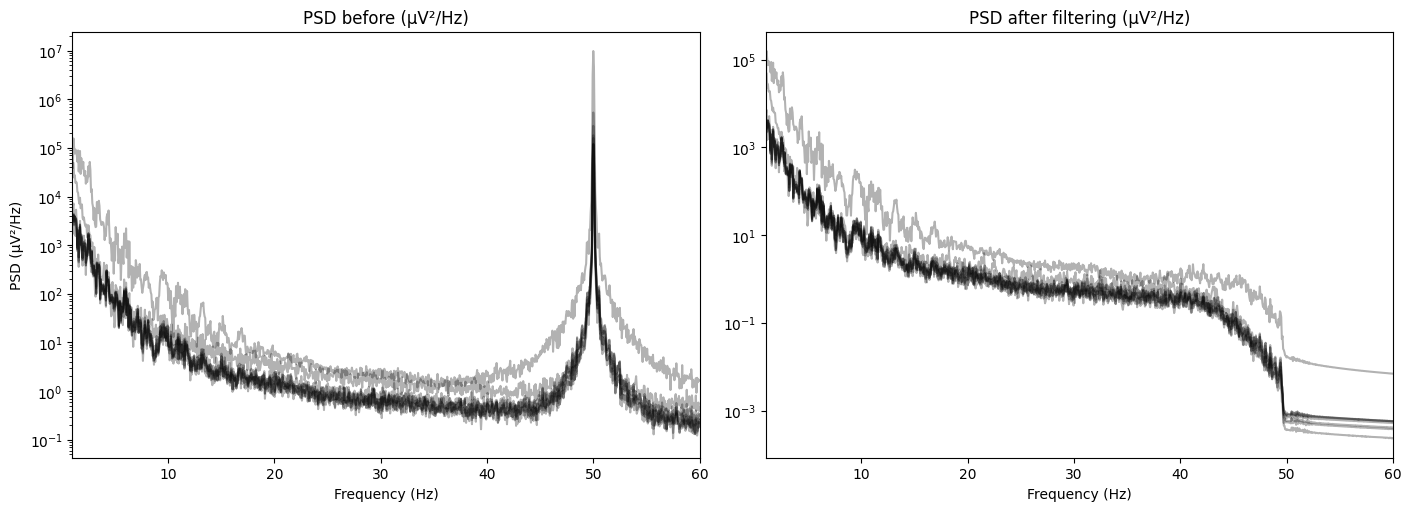

Saved PSD figure to: eeg_analysis_outputs/psd_before_after_uV.png


In [18]:
# ------------------ CELL: PSD before / after (µV^2/Hz) ------------------
plot_picks = eeg_picks  # change to a subset if you have many channels

n_fft_plot = choose_n_fft(raw, target=4096)
psd_before, freqs = compute_psd(raw, picks=plot_picks, fmin=1.0, fmax=60.0, n_fft=n_fft_plot, n_overlap=0, n_jobs=1)
psd_after, _ = compute_psd(raw_clean, picks=plot_picks, fmin=1.0, fmax=60.0, n_fft=n_fft_plot, n_overlap=0, n_jobs=1)

# Convert PSD from V^2/Hz -> µV^2/Hz
factor = 1e12
psd_before_uV = psd_before * factor
psd_after_uV  = psd_after  * factor

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)
axes[0].set_title("PSD before (µV²/Hz)")
for ii in range(psd_before_uV.shape[0]):
    axes[0].semilogy(freqs, psd_before_uV[ii], color='k', alpha=0.3)
axes[0].set_xlim(1, 60)
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("PSD (µV²/Hz)")

axes[1].set_title("PSD after filtering (µV²/Hz)")
for ii in range(psd_after_uV.shape[0]):
    axes[1].semilogy(freqs, psd_after_uV[ii], color='k', alpha=0.3)
axes[1].set_xlim(1, 60)
axes[1].set_xlabel("Frequency (Hz)")

fig_path = os.path.join(out_dir, "psd_before_after_uV.png")
fig.savefig(fig_path, dpi=150)
plt.show()
print("Saved PSD figure to:", fig_path)

In [19]:
# ------------------ CELL: band-power calculation (µV^2 & relative %) ------------------
bands = {
    'delta': (1.0, 4.0),
    'theta': (4.0, 8.0),
    'alpha': (8.0, 13.0),
    'beta':  (13.0, 30.0),
    'gamma': (30.0, 40.0),
}

n_fft_bp = choose_n_fft(raw_clean, target=4096)
psds, freqs = compute_psd(raw_clean, picks=eeg_picks, fmin=1.0, fmax=40.0, n_fft=n_fft_bp, n_overlap=0, n_jobs=1)

band_power = pd.DataFrame(index=[raw_clean.ch_names[p] for p in eeg_picks])
total_power = np.trapz(psds, freqs, axis=1)   # V^2 in 1-40 Hz
band_power['total_V2'] = total_power
band_power['total_uV2'] = band_power['total_V2'] * 1e12

for bname, (fmin, fmax) in bands.items():
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    p = np.trapz(psds[:, idx], freqs[idx], axis=1)
    band_power[f'{bname}_V2'] = p
    band_power[f'{bname}_uV2'] = p * 1e12
    band_power[f'{bname}_pct'] = 100.0 * (p / band_power['total_V2'])

display(band_power.sort_values('alpha_pct', ascending=False).head(12))
csv_bands = os.path.join(out_dir, "band_power_per_channel.csv.gz")
band_power.to_csv(csv_bands, compression='gzip')
print("Saved band-power table to", csv_bands)

/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3919/3367965186.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_power = np.trapz(psds, freqs, axis=1)   # V^2 in 1-40 Hz
/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3919/3367965186.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p = np.trapz(psds[:, idx], freqs[idx], axis=1)
/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3919/3367965186.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p = np.trapz(psds[:, idx], freqs[idx], axis=1)
/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3919/3367965186.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integrati

,total_V2,total_uV2,delta_V2,delta_uV2,delta_pct,theta_V2,theta_uV2,theta_pct,alpha_V2,alpha_uV2,alpha_pct,beta_V2,beta_uV2,beta_pct,gamma_V2,gamma_uV2,gamma_pct
EXG 1,3.322719e-09,3322.718941,3.002396e-09,3002.395982,90.359613,2.392575e-10,239.257474,7.200653,4.505641e-11,45.056411,1.356010,2.418641e-11,24.186411,0.727910,4.923140e-12,4.923140,0.148166
EXG 3,3.002969e-09,3002.969332,2.710803e-09,2710.802746,90.270744,2.186649e-10,218.664875,7.281622,3.962990e-11,39.629896,1.319690,2.235589e-11,22.355886,0.744459,4.294777e-12,4.294777,0.143018
EXG 5,3.335199e-09,3335.198585,3.032578e-09,3032.577531,90.926446,2.311656e-10,231.165628,6.931090,4.087116e-11,40.871159,1.225449,1.967852e-11,19.678516,0.590025,3.588574e-12,3.588574,0.107597
EXG 2,3.234011e-09,3234.011313,2.942558e-09,2942.557913,90.987867,2.218732e-10,221.873229,6.860620,3.827225e-11,38.272251,1.183430,2.022752e-11,20.227523,0.625462,4.254521e-12,4.254521,0.131556
EXG 8,2.815249e-09,2815.248849,2.571895e-09,2571.895465,91.355884,1.820089e-10,182.008900,6.465109,2.994511e-11,29.945108,1.063675,1.873986e-11,18.739864,0.665656,4.445238e-12,4.445238,0.157899
EXG 6,3.978887e-09,3978.886731,3.701109e-09,3701.108855,93.018704,2.101222e-10,210.122241,5.280930,3.483259e-11,34.832593,0.875436,2.093300e-11,20.932999,0.526102,5.059426e-12,5.059426,0.127157
EXG 4,1.007253e-07,100725.337307,9.647661e-08,96476.606270,95.781865,3.544361e-09,3544.361188,3.518838,4.446506e-10,444.650591,0.441449,1.208434e-10,120.843366,0.119973,1.300594e-11,13.005942,0.012912
EXG 7,1.801800e-08,18017.997067,1.762669e-08,17626.694669,97.828269,2.773223e-10,277.322291,1.539141,5.316321e-11,53.163209,0.295056,3.441726e-11,34.417263,0.191016,7.615331e-12,7.615331,0.042265
TRIG,0.000000e+00,0.000000,0.000000e+00,0.000000,NaN,0.000000e+00,0.000000,NaN,0.000000e+00,0.000000,NaN,0.000000e+00,0.000000,NaN,0.000000e+00,0.000000,NaN


Saved band-power table to eeg_analysis_outputs/band_power_per_channel.csv.gz


In [20]:
# ------------------ CELL: ICA (optional) ------------------
from mne.preprocessing import ICA

n_eeg = len(eeg_picks)
if n_eeg < 3:
    print("Too few EEG channels for ICA (need >= 3). Skipping ICA.")
else:
    n_components = min(8, n_eeg)  # adjust as needed
    print("Fitting ICA with n_components =", n_components, "(this may take a while)")
    ica = ICA(n_components=n_components, random_state=97, max_iter='auto')
    try:
        ica.fit(raw_clean, picks=eeg_picks)
        print("ICA fitted. Inspect with: ica.plot_components(), ica.plot_sources(raw_clean)")
    except Exception as exc:
        print("ICA failed:", exc)
        ica = None

# If you visually pick components to exclude, set components_to_remove and apply:
components_to_remove = [0, 2]
if ica is not None and components_to_remove:
    ica.exclude = components_to_remove
    raw_ica_clean = raw_clean.copy()
    ica.apply(raw_ica_clean)
else:
    raw_ica_clean = raw_clean

Fitting ICA with n_components = 8 (this may take a while)
Fitting ICA to data using 9 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.2s.
ICA fitted. Inspect with: ica.plot_components(), ica.plot_sources(raw_clean)
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 9 PCA components


In [21]:
# ------------------ CELL: events detection & epoching ------------------
events = None
event_id = None

# 1) Try annotations (recommended)
if hasattr(raw, 'annotations') and len(raw.annotations) > 0:
    try:
        events, event_id = mne.events_from_annotations(raw)
        print("Events extracted from annotations:", events.shape, "event_id:", event_id)
    except Exception as exc:
        print("events_from_annotations failed:", exc)
        events = None

# 2) If no annotations, look for stim channel(s)
if events is None or events.size == 0:
    stim_picks = mne.pick_types(raw.info, stim=True)
    if len(stim_picks) > 0:
        stim_ch = raw.ch_names[stim_picks[0]]
        try:
            events = mne.find_events(raw, stim_channel=stim_ch, shortest_event=1, verbose=False)
            print("Events found on stim channel", stim_ch, "->", events.shape)
        except Exception as exc:
            print("mne.find_events failed on", stim_ch, ":", exc)
            events = None

# 3) Fallback: scan channels for discrete steps (analog triggers)
if (events is None or events.size == 0):
    for ch in raw.ch_names:
        if 'status' in ch.lower() or 'stim' in ch.lower() or 'trigger' in ch.lower():
            idx = raw.ch_names.index(ch)
            arr = raw.get_data(picks=[idx])[0]
            vals = np.round(arr).astype(int)
            diffs = np.diff(vals)
            edges = np.where(diffs != 0)[0] + 1
            if len(edges) > 0:
                events = np.column_stack((edges, np.zeros_like(edges, dtype=int), vals[edges]))
                print("Fallback found transitions in", ch, "->", events.shape[0], "events")
                break

if events is None or events.size == 0:
    print("No events found (annotations or stim-like channels).")
else:
    # Build event_id mapping from unique codes (if integer codes present)
    unique_codes = np.unique(events[:, 2])
    event_id = {str(int(c)): int(c) for c in unique_codes}
    print("Auto event_id mapping:", event_id)
    tmin, tmax = -0.2, 0.8
    epochs = mne.Epochs(raw_clean, events, event_id=event_id, tmin=tmin, tmax=tmax,
                        baseline=(None, 0), picks=eeg_picks, preload=True)
    print("Created epochs:", epochs)
    # Plot average (evoked) for up to first 3 codes
    shown = 0
    for k, code in enumerate(event_id):
        try:
            ev = epochs[code].average()
            ev.plot(title=f"Evoked {code}", show=True)
            shown += 1
            if shown >= 3:
                break
        except Exception:
            pass

No events found (annotations or stim-like channels).


Spectrogram channel: EXG 1
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


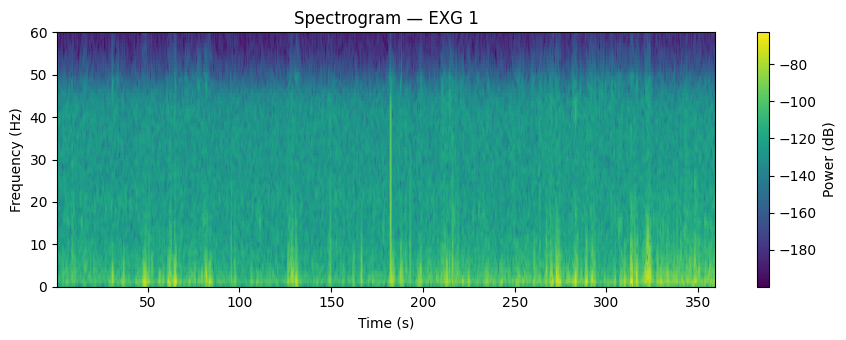

Saved spectrogram to: eeg_analysis_outputs/spectrogram_EXG_1.png
Writing /Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/Raw Data Recorder/eeg_analysis_outputs/raw_filtered.fif
Closing /Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/Raw Data Recorder/eeg_analysis_outputs/raw_filtered.fif
[done]
Saved filtered raw (FIF) to: eeg_analysis_outputs/raw_filtered.fif


/var/folders/6f/twg_bwys7xb6mgr86_05x41m0000gn/T/ipykernel_3919/3232590535.py:28: RuntimeWarning: This filename (/Users/stageacomeback/Desktop/Gerard Lee/PolyU SPEED RA/EEG Brain Signal Analysis/Self Testing (gtec Sample Dataset)/Raw Data Recorder/eeg_analysis_outputs/raw_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_clean.save(out_fif, overwrite=True)


Saved filtered timeseries (compressed) to: eeg_analysis_outputs/raw_filtered_timeseries.csv.gz size (MB): 6.8016462326049805


In [22]:
# ------------------ CELL: spectrogram & saving processed data ------------------
if len(eeg_picks) == 0:
    ch_spec = raw.ch_names[0]
else:
    ch_spec = raw.ch_names[eeg_picks[0]]
print("Spectrogram channel:", ch_spec)

sig = raw_clean.copy().pick_channels([ch_spec]).get_data()[0]  # Volts
sfreq = raw_clean.info['sfreq']

f, t, Sxx = spectrogram(sig, fs=sfreq, nperseg=256, noverlap=128, scaling='density')
plt.figure(figsize=(9, 3.5))
plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-20), shading='gouraud', cmap='viridis')
plt.colorbar(label='Power (dB)')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.ylim(0, 60)
plt.title(f"Spectrogram — {ch_spec}")
spec_path = os.path.join(out_dir, f"spectrogram_{ch_spec.replace(' ', '_')}.png")
plt.tight_layout()
plt.savefig(spec_path, dpi=150)
plt.show()
print("Saved spectrogram to:", spec_path)

# Save filtered raw (FIF) and a compressed CSV timeseries (can be large)
out_fif = os.path.join(out_dir, "raw_filtered.fif")
try:
    raw_clean.save(out_fif, overwrite=True)
    print("Saved filtered raw (FIF) to:", out_fif)
except Exception as exc:
    print("Could not save .fif:", exc)

csv_out = os.path.join(out_dir, "raw_filtered_timeseries.csv.gz")
try:
    df = raw_clean.to_data_frame()   # note: may scale EEG to µV automatically
    df.to_csv(csv_out, compression="gzip")
    print("Saved filtered timeseries (compressed) to:", csv_out, "size (MB):", os.path.getsize(csv_out) / (1024**2))
except Exception as exc:
    print("Could not save timeseries CSV:", exc)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



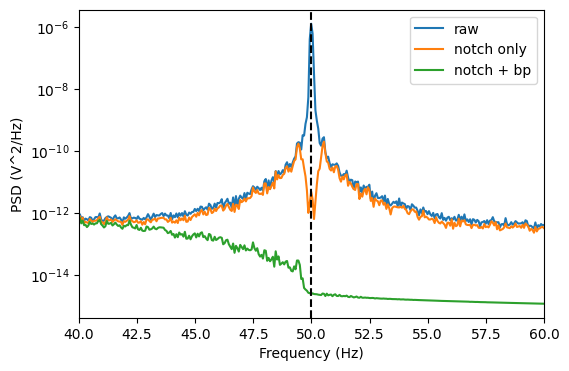

In [23]:
# reuse your compute_psd wrapper
picks = eeg_picks  # or a single channel index list
psd_raw, freqs = compute_psd(raw, picks=picks, fmin=1.0, fmax=60.0, n_fft=4096)
# notch only (copy)
raw_notch = raw.copy().load_data()
raw_notch.notch_filter(freqs=[50.0, 100.0], picks=picks, fir_design='firwin')
psd_notch, _ = compute_psd(raw_notch, picks=picks, fmin=1.0, fmax=60.0, n_fft=4096)
# notch + bandpass
raw_bpf = raw_notch.copy()
raw_bpf.filter(1.0, 40.0, picks=picks, fir_design='firwin')
psd_bpf, _ = compute_psd(raw_bpf, picks=picks, fmin=1.0, fmax=60.0, n_fft=4096)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.semilogy(freqs, psd_raw.mean(axis=0), label='raw')
plt.semilogy(freqs, psd_notch.mean(axis=0), label='notch only')
plt.semilogy(freqs, psd_bpf.mean(axis=0), label='notch + bp')
plt.xlim(40, 60)
plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD (V^2/Hz)')
plt.axvline(50, color='k', linestyle='--'); plt.legend(); plt.show()

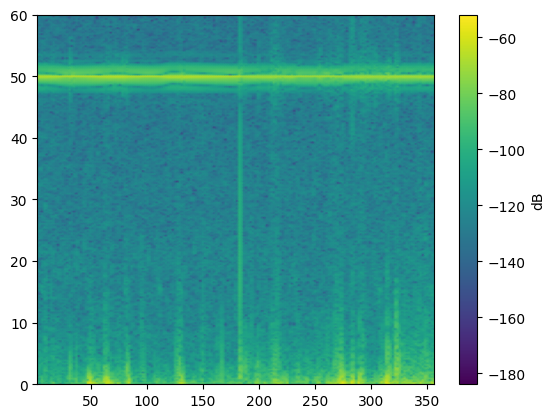

In [24]:
from scipy.signal import spectrogram
ch = raw.ch_names[eeg_picks[0]]
sig = raw.get_data(picks=[eeg_picks[0]])[0]
f,t,Sxx = spectrogram(sig, fs=raw.info['sfreq'], nperseg=1024, noverlap=512, scaling='density')
plt.pcolormesh(t, f, 10*np.log10(Sxx+1e-20), shading='gouraud'); plt.ylim(0,60); plt.colorbar(label='dB'); plt.show()

In [25]:
from scipy.signal import iirnotch, filtfilt
fs = raw.info['sfreq']
b,a = iirnotch(w0=50.0, Q=30.0, fs=fs)   # Q controls narrowness; increase Q for narrower notch
raw_iir = raw.copy().load_data()
picks = mne.pick_types(raw.info, eeg=True, meg=False, stim=False)
for ch in picks:
    raw_iir._data[ch] = filtfilt(b, a, raw_iir._data[ch])
# then compute PSD on raw_iir and compare